# Imports

In [47]:
# Import libraries
# !pip install --upgrade pandas
# !pip install prophet
# !pip install -U numpy
# !pip uninstall pillow
# !pip install pillow
# !pip install -U scipy
# !pip install matplotlib
# !pip install seaborn matplotlib
# !pip install statsmodels
# !pip install scikit-learn

import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import numpy as np
import numpy.ma as ma

from scipy import stats

import seaborn as sns
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV

# Ignore future warning logs
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ignore convergence warning logs
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

import logging

import xgboost as xgb

from objects.column import Column
from objects.region import Region
from models.model import preprocessDataframeForRegion, trainXGBOOST, trainXGBOOSTWithCrossValidation, trainXGBOOSTWithGridSearchCV
from util import *


<!-- pip install --upgrade pandas && pip install prophet && pip install -U numpy && pip uninstall pillow && pip install pillow && pip install -U scipy && pip install matplotlib && pip install seaborn matplotlib && pip install statsmodels && pip install sklearn -->

# Info about our dataset

On the dataset we are going to examine we have data downloaded from the Hass Avocado Board website in May of 2018. The data represents weekly retail scanned data for National retail volume (units) and price between 2015 and 2018.

The columns of the csv file are the following:

- Unnamed column that represents the number of weeks left for the end of the year of the observation
- Date - The date of the observation
- AveragePrice - the average price of a single avocado
- Total Volume - Total number of avocados sold
- 4046 - Total number of avocados with PLU 4046 sold
- 4225 - Total number of avocados with PLU 4225 sold
- 4770 - Total number of avocados with PLU 4770 sold
- Total Bags - Total number of bags of avocados sold
- Small Bags - Total number of small bags of avocados sold
- Large Bags - Total number of large bags of avocados sold
- XLarge Bags - Total number of xlarge bags of avocados sold
- type - conventional or organic
- year - the year of the observation
- region - the city or region of the observation

In [48]:
# Load the dataset
avocado_df = pd.read_csv('./data/avocado.csv')

avocado_df.head()


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


# Delete index column

As the unnmaed column that represents the number of weeks left for the end of the year of the observation does not seem of use we will remove it

In [49]:
# avocado_df = avocado_df.drop(list(avocado_df)[0], axis=1)

# avocado_df.head()
avocado_df=avocado_df.rename(columns={'Unnamed: 0':'weeks_left'}) 

avocado_df['WeekOfYear'] = 52-avocado_df['weeks_left']


# Exploratory Data Analysis

## Regions

We will examine first the regions column, its distribution and an interesting fact that we need to consider in our analysis 

In [50]:
regions = avocado_df['region'].value_counts()

print("Number of regions on the dataset are",len(regions))


Number of regions on the dataset are 54


As we can see on the next histogram most of the regions/cities of our dataset have 338 observations

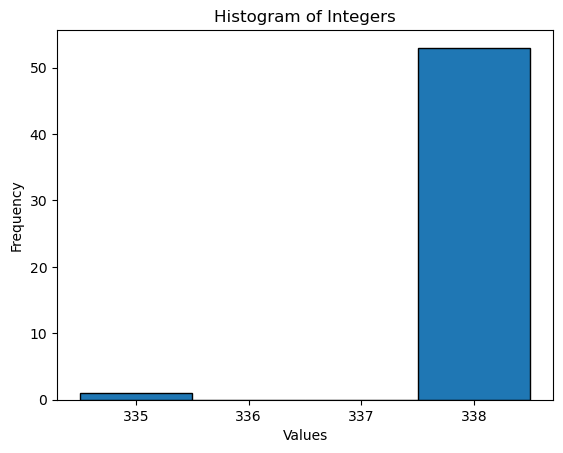

In [51]:
plotRegionObservations(regions)


As we will see below the only region with 335 observations is WestTexNewMexico

In [52]:
findRegionsByNumberObservations(regions, 335)


WestTexNewMexico 335


One of the important facts we need to consider about this dataset though is that there is a region named TotalUS

In [53]:
findRegionsByName(regions, "TotalUS")


TotalUS 338


That means in order to examine the whole US and then the weight for each region we should not work on the whole dataset and the each different region.

We need to filter the dataframe and work with the observations that have the value TotalUS as region to understand what happens to US as a whole.

Of course once we need to examine each region on its own or compared to whole US we need to take into account for the region WestTexNewMexico that it has 3 less observations.

## Summary statistics for Total US

### Distributions of columns: ;

We will calculate summary stats like mean, median, min, max, quantiles, etc. for each column to understand distributions. After that the next step will be to use boxplots and histograms as well.

Before doing that we will do a check to see the type of data each column holds

In [54]:
total_us_df = avocado_df[avocado_df["region"]=="TotalUS"]

#Types of columns
print(total_us_df.dtypes)


weeks_left        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
WeekOfYear        int64
dtype: object


As not every column holds numeric data (float or int) we will focus on the numeric ones

#### Summary stats

In [55]:
print(total_us_df.describe())


       weeks_left  AveragePrice  Total Volume          4046          4225  \
count  338.000000    338.000000  3.380000e+02  3.380000e+02  3.380000e+02   
mean    24.236686      1.319024  1.735130e+07  6.079693e+06  5.961573e+06   
std     15.506203      0.295460  1.696847e+07  6.190955e+06  5.902679e+06   
min      0.000000      0.760000  5.018149e+05  7.775993e+04  1.988741e+05   
25%     10.000000      1.040000  9.697335e+05  1.320755e+05  2.884968e+05   
50%     24.000000      1.325000  1.141233e+07  3.691228e+06  3.766042e+06   
75%     38.000000      1.540000  3.294982e+07  1.205711e+07  1.135061e+07   
max     52.000000      2.090000  6.250565e+07  2.274362e+07  2.047057e+07   

               4770    Total Bags    Small Bags    Large Bags    XLarge Bags  \
count  3.380000e+02  3.380000e+02  3.380000e+02  3.380000e+02     338.000000   
mean   4.620568e+05  4.847931e+06  3.679175e+06  1.105279e+06   63477.013432   
std    5.491311e+05  4.889033e+06  3.677292e+06  1.184979e+06   98

##### Organic Avocados

In [56]:
print(total_us_df[total_us_df.type=="organic"].describe())


       weeks_left  AveragePrice  Total Volume           4046           4225  \
count  169.000000    169.000000  1.690000e+02     169.000000     169.000000   
mean    24.236686      1.546036  9.675657e+05  148404.667515  308284.424201   
std     15.529261      0.202764  3.024823e+05   53212.205731   77183.319695   
min      0.000000      1.000000  5.018149e+05   77759.930000  198874.090000   
25%     10.000000      1.430000  6.997633e+05  109023.660000  250138.660000   
50%     24.000000      1.530000  9.678861e+05  132040.040000  287724.610000   
75%     38.000000      1.670000  1.148617e+06  171054.380000  347488.780000   
max     52.000000      2.090000  1.814930e+06  361996.840000  680037.450000   

               4770    Total Bags     Small Bags     Large Bags  XLarge Bags  \
count    169.000000  1.690000e+02     169.000000     169.000000   169.000000   
mean    5409.545503  5.053699e+05  358176.323550  147170.631775    22.880414   
std     3914.029770  2.793308e+05  229695.844747

##### Conventional Avocados

In [57]:
print(total_us_df[total_us_df.type=="conventional"].describe())


       weeks_left  AveragePrice  Total Volume          4046          4225  \
count  169.000000    169.000000  1.690000e+02  1.690000e+02  1.690000e+02   
mean    24.236686      1.092012  3.373504e+07  1.201098e+07  1.161486e+07   
std     15.529261      0.174119  6.118092e+06  2.470219e+06  2.363234e+06   
min      0.000000      0.760000  2.100973e+07  7.020459e+06  6.852046e+06   
25%     10.000000      0.970000  2.976164e+07  1.032046e+07  1.019789e+07   
50%     24.000000      1.040000  3.299401e+07  1.209132e+07  1.135428e+07   
75%     38.000000      1.190000  3.702609e+07  1.326275e+07  1.299833e+07   
max     52.000000      1.650000  6.250565e+07  2.274362e+07  2.047057e+07   

               4770    Total Bags    Small Bags    Large Bags    XLarge Bags  \
count  1.690000e+02  1.690000e+02  1.690000e+02  1.690000e+02     169.000000   
mean   9.187040e+05  9.190493e+06  7.000174e+06  2.063387e+06  126931.146450   
std    4.305041e+05  3.151089e+06  2.209822e+06  9.805227e+05  106

#### Boxplots

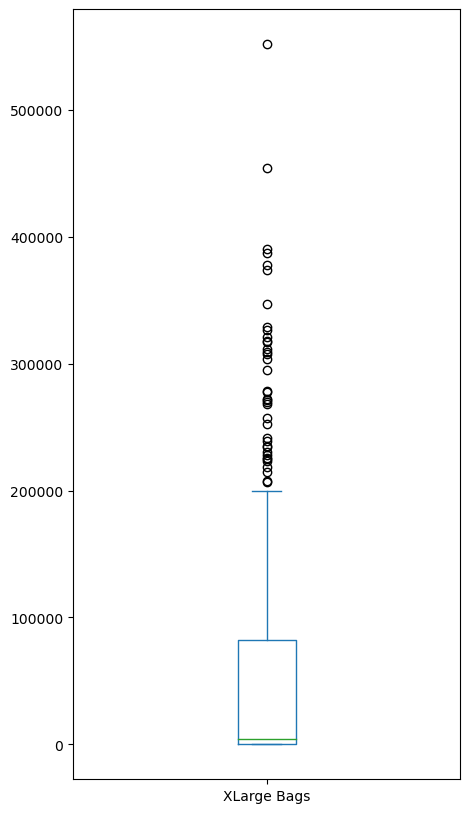

In [58]:
boxplotOfColumn(total_us_df,'XLarge Bags')


#### Histograms

In [59]:
total_us_df = total_us_df.sort_values(by='Date').reset_index(drop=True)


<Figure size 800x31500 with 0 Axes>

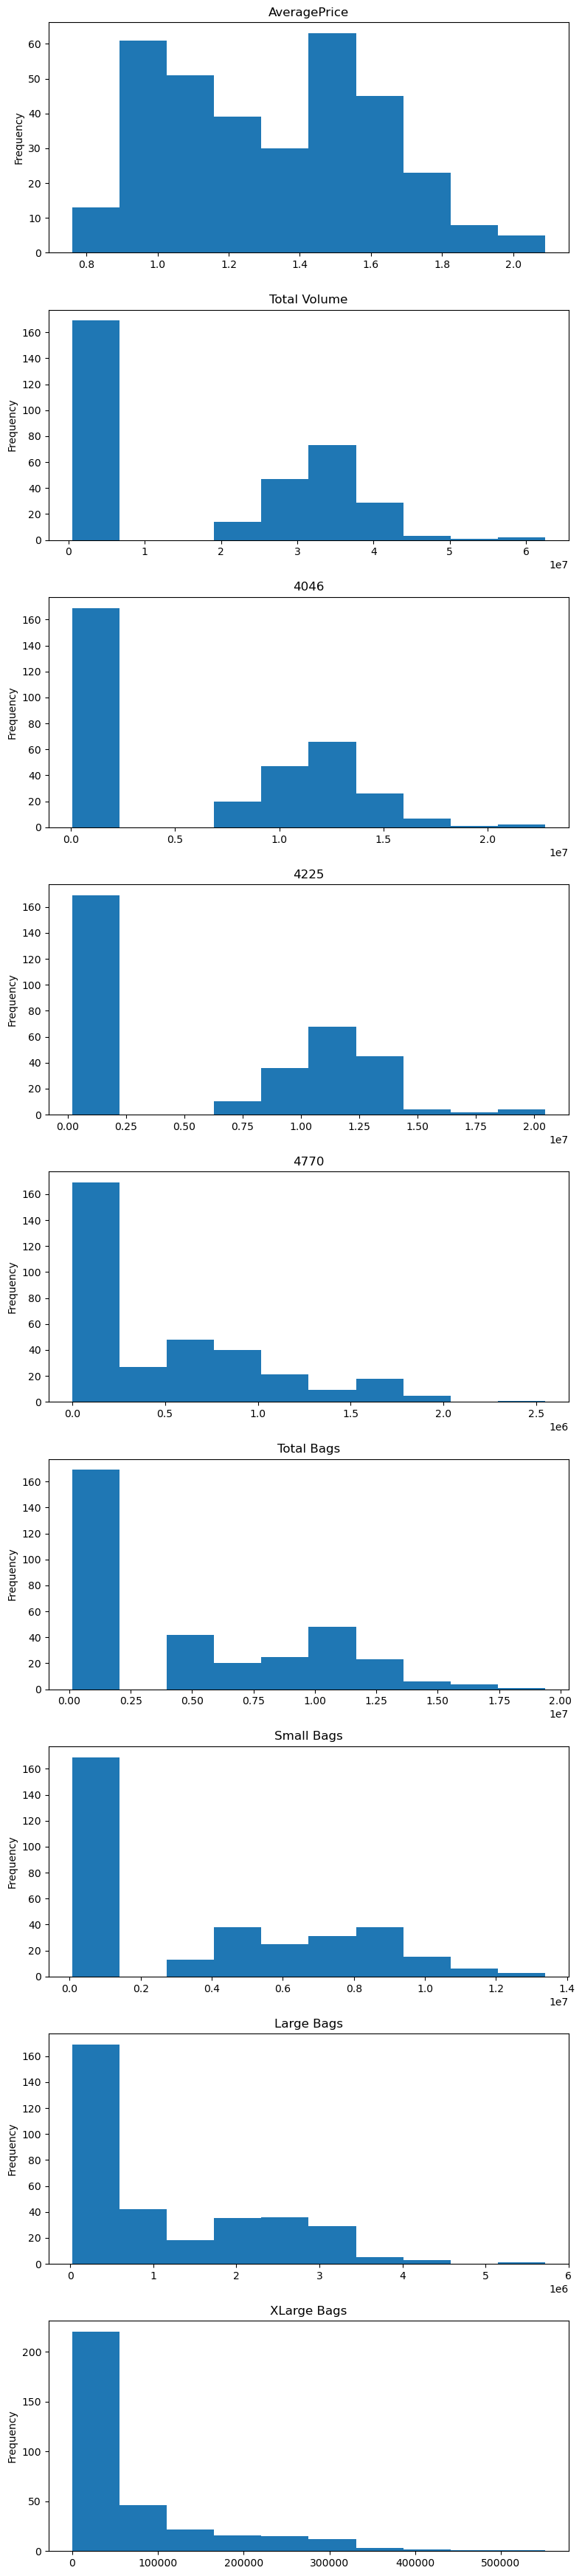

In [60]:
histogramsOfDataframe(total_us_df)


## Analyze trends over time - create line charts for average price, volume, bags sold, etc. over the date range to visually inspect trends and seasonality.

### Average Price trends

To examine the trends for average price we are going to plot a graph for each year and then try to compare the years to see obvious patterns based on seasonality.

First step is to create a new dataframe that will combine the duplicate rows for the same date as the current dataset has one row for each date, one for the organic avocados observation and the other for the conventional. Then this new dataframe will be used to plot our graphs.

In [61]:
# Pivot the DataFrame to have 'Date' as the index and 'Type' as columns
pivot_df = total_us_df.pivot(index=['Date','year','WeekOfYear'], columns='type', values='AveragePrice')

# Calculate the average of 'Organic' and 'Conventional' columns
pivot_df['AveragePriceCombined'] = pivot_df.mean(axis=1)

# Reset the index to have 'Date' as a regular column
result_df = pivot_df.reset_index()

# Optionally, you can rename the columns as needed
result_df.rename(columns={'Date': 'Date', 'AveragePriceCombined': 'AveragePrice','organic':'Organic','conventional':'Conventional'}, inplace=True)


The graphs will have 3 lines. One line will be the average price of the organic avocados through the year, the other for the conventional and the final one will be the combination of the first two.

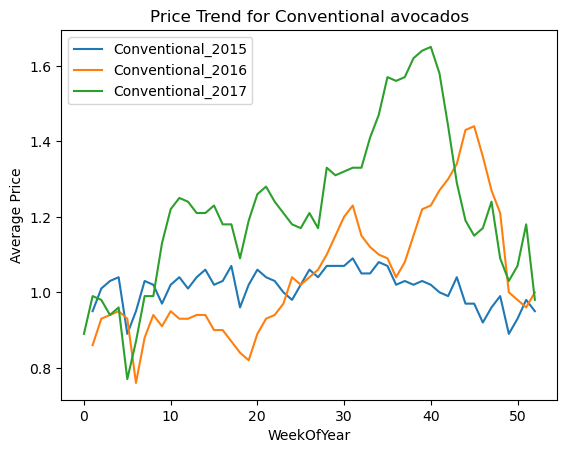

In [62]:
plotConventionalAvocadosAveragePriceForYears(result_df)


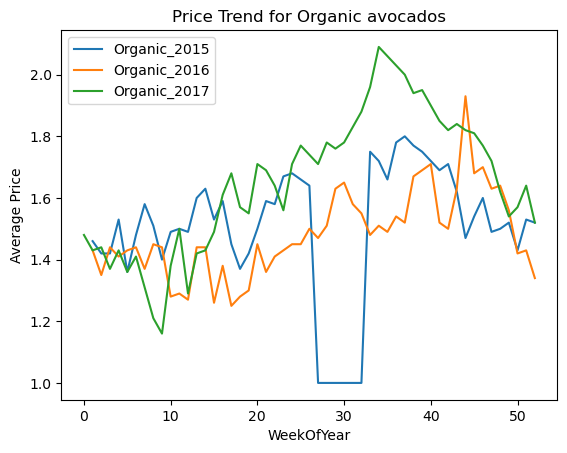

In [63]:
plotOrganicAvocadosAveragePriceForYears(result_df)


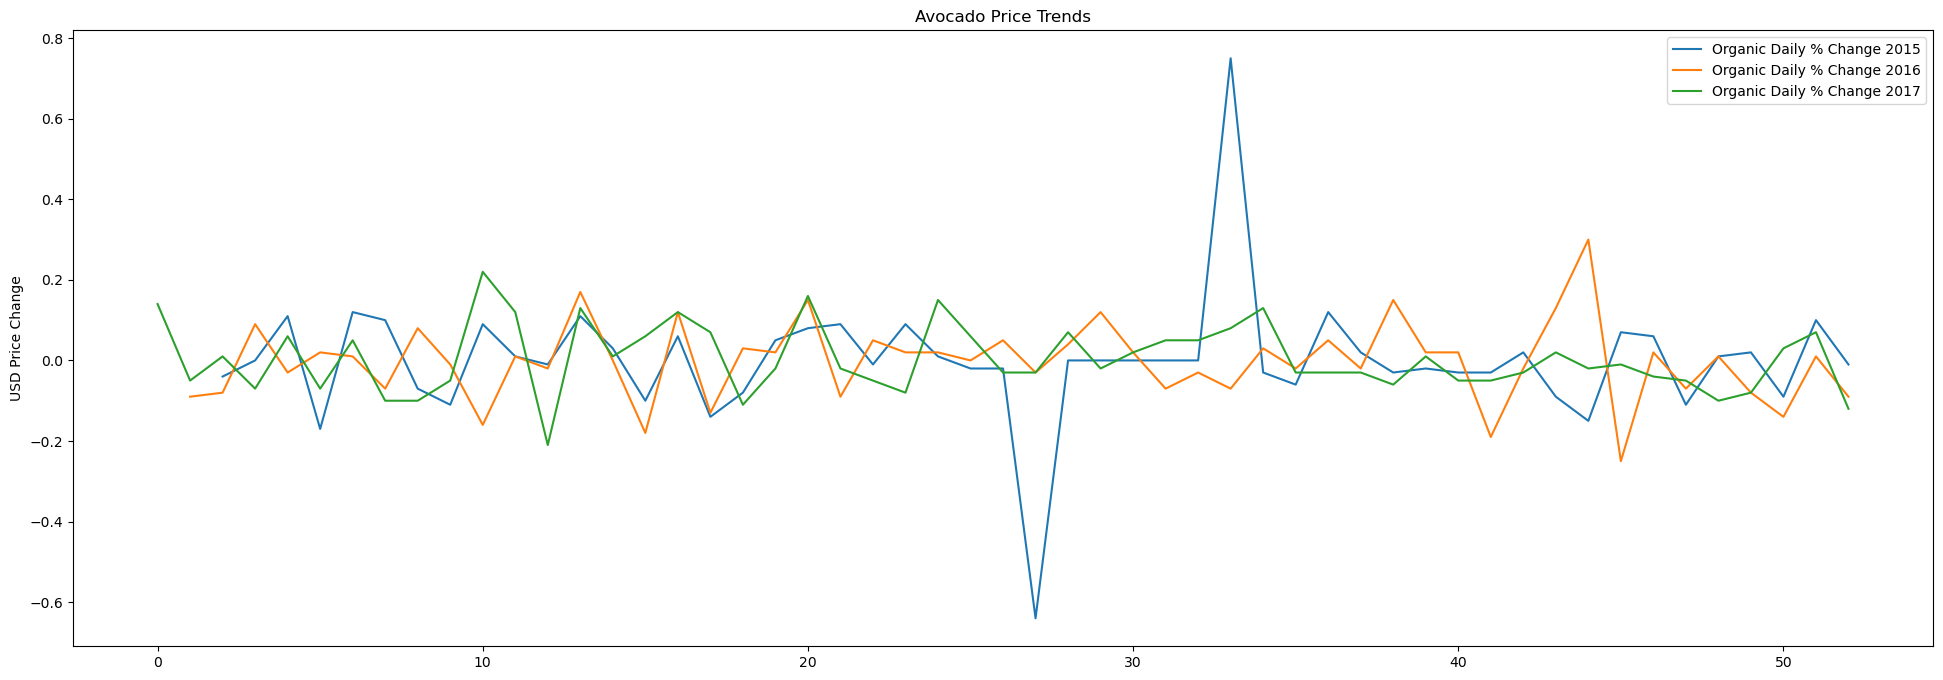

In [64]:
plotAveragePriceTrendPerYear(result_df, 'Organic')


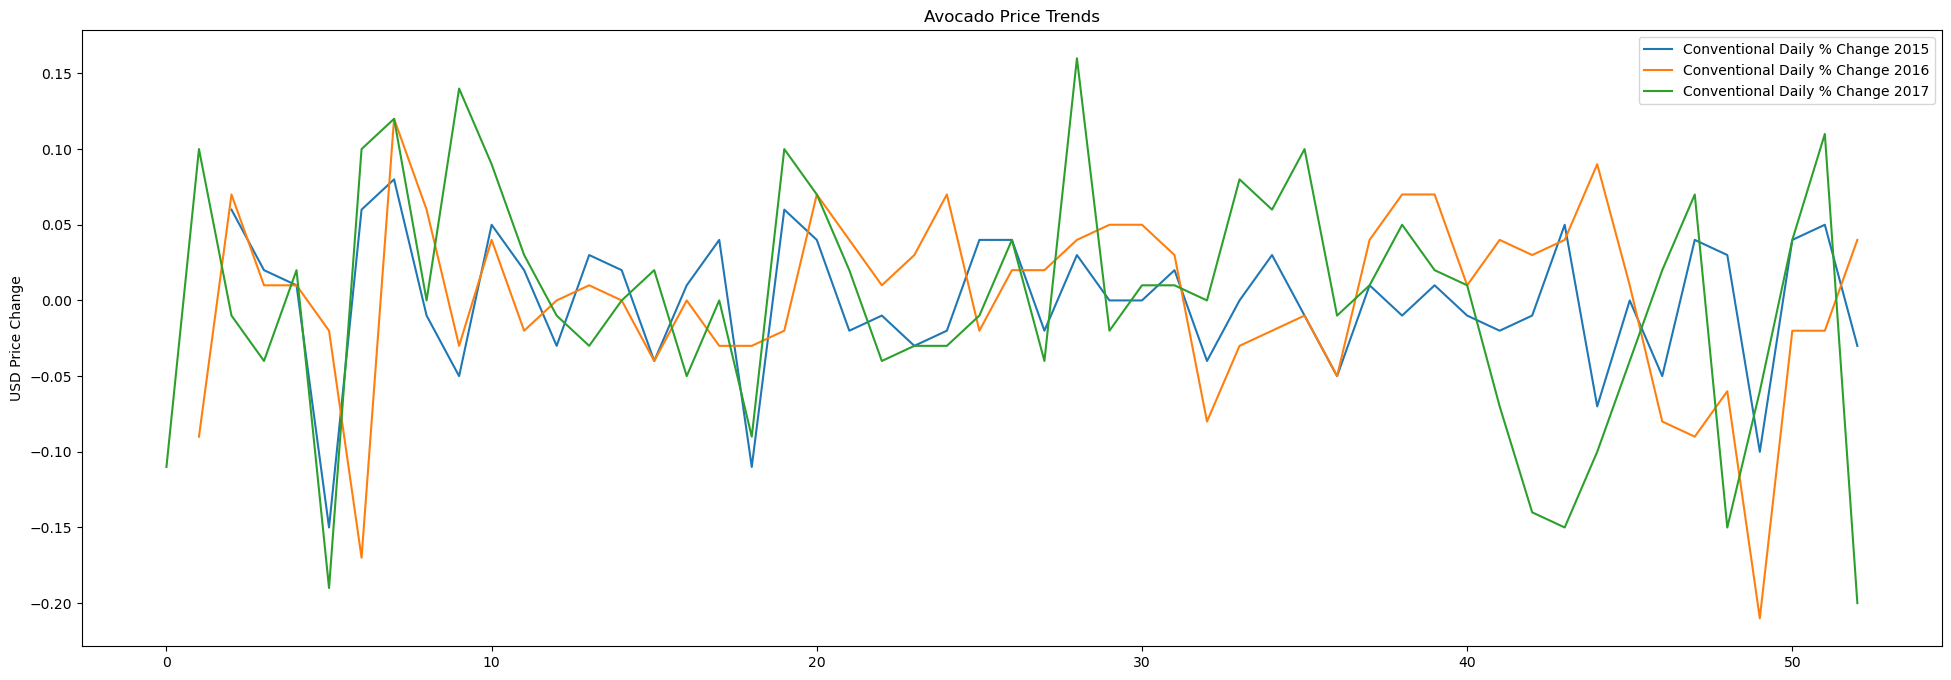

In [65]:
plotAveragePriceTrendPerYear(result_df, 'Conventional')


One of the first observations from the graphs above is that it seems there is a peak between August and October for the prices of Avocados for both the organic and conventional types. From October and till the end of the year there is a decline on the Average Price.

To understand if this decline is driven by less demand we will plot the graphs for Total Volume of avocados being sold in the whole US like we just did for the Average Price.

### Total volume trends

As the difference between volume of conventional and organic is big we will plot them in different graphs to avoid seeing a flat line for the total volume of organic.

In [66]:
# Pivot the DataFrame to have 'Date' as the index and 'Type' as columns
pivot_df = total_us_df.pivot(index=['Date','year'], columns='type', values='Total Volume')

# Calculate the average of 'Organic' and 'Conventional' columns
pivot_df['TotalVolumeCombined'] = pivot_df.mean(axis=1)

# Reset the index to have 'Date' as a regular column
result_df = pivot_df.reset_index()

# Optionally, you can rename the columns as needed
result_df.rename(columns={'Date': 'Date', 'TotalVolumeCombined': 'TotalVolume','organic':'Organic','conventional':'Conventional'}, inplace=True)


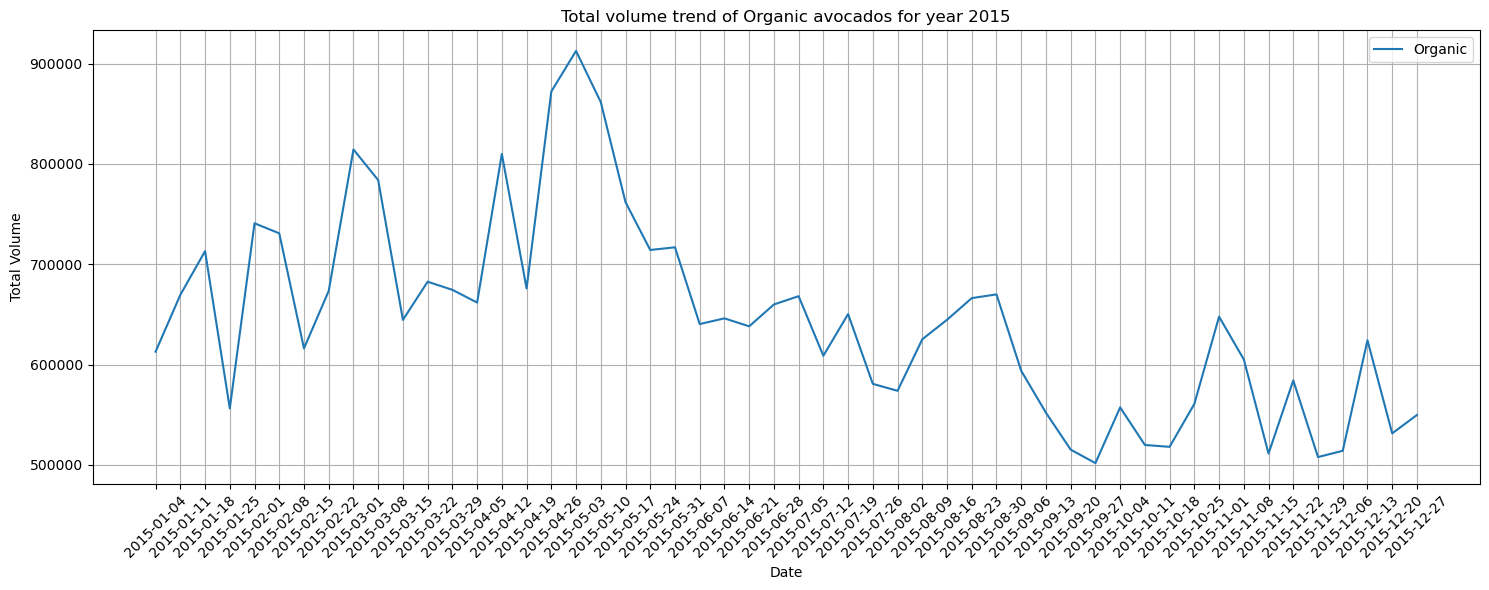

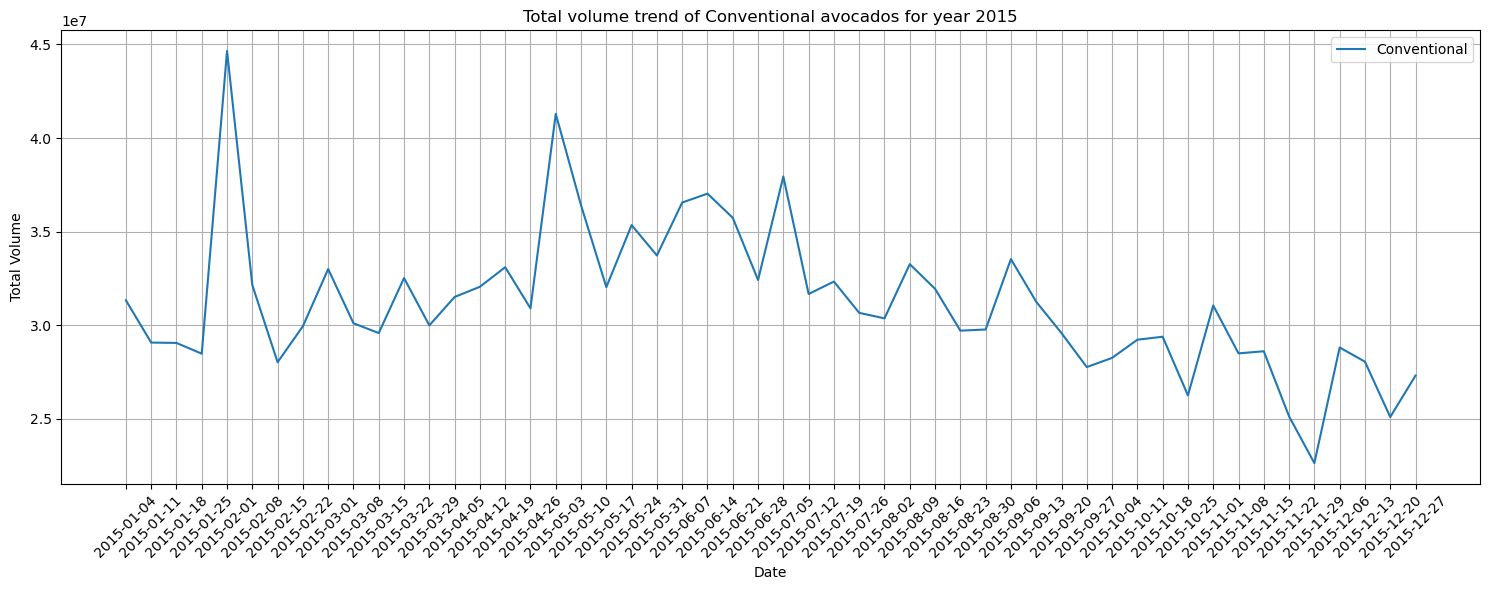

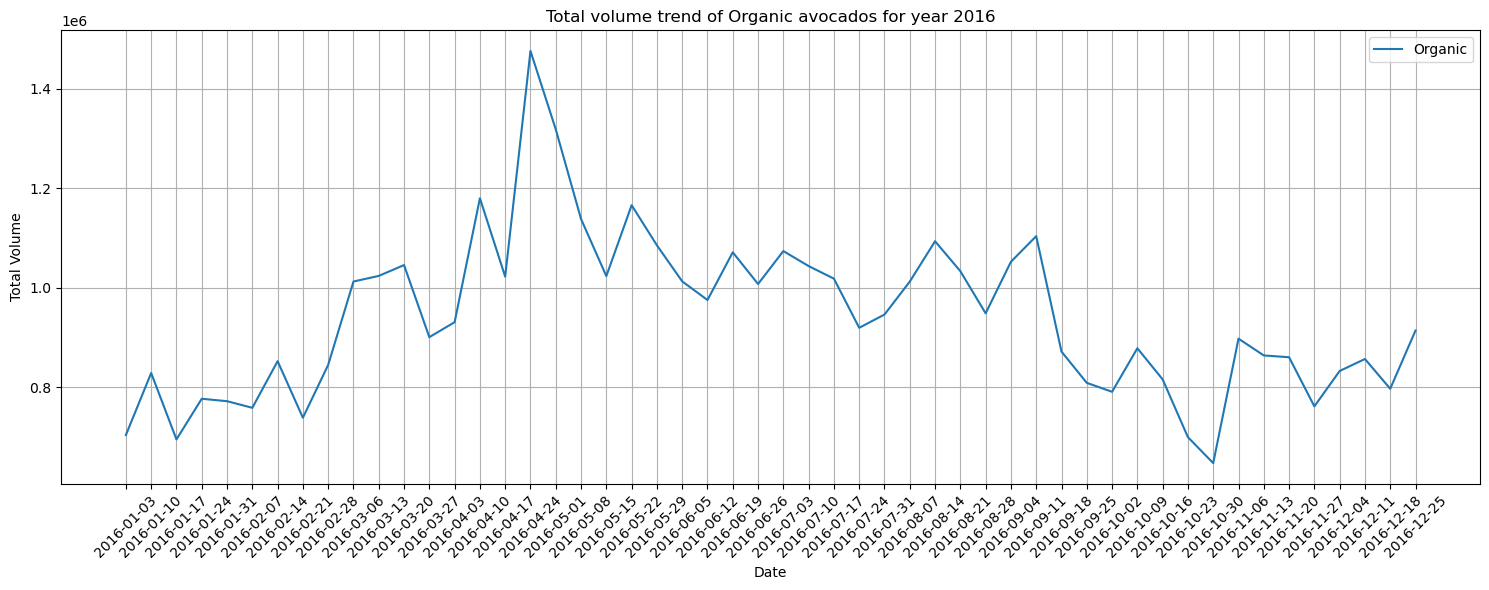

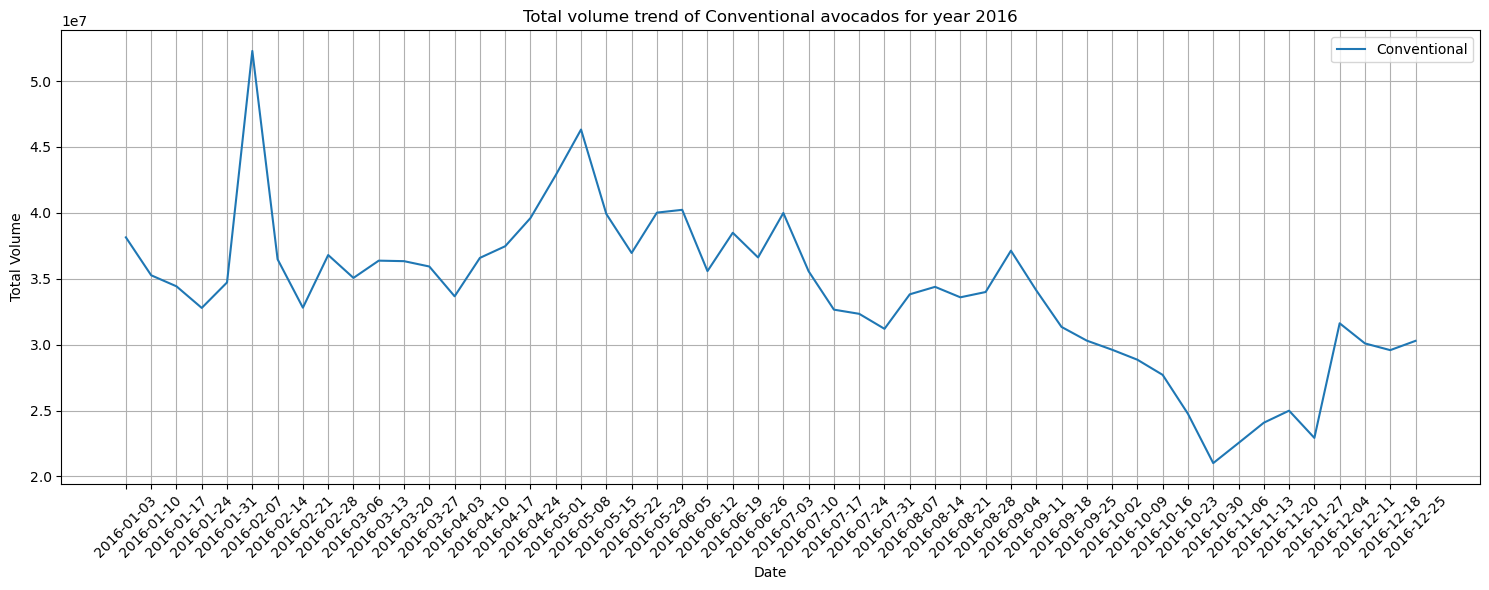

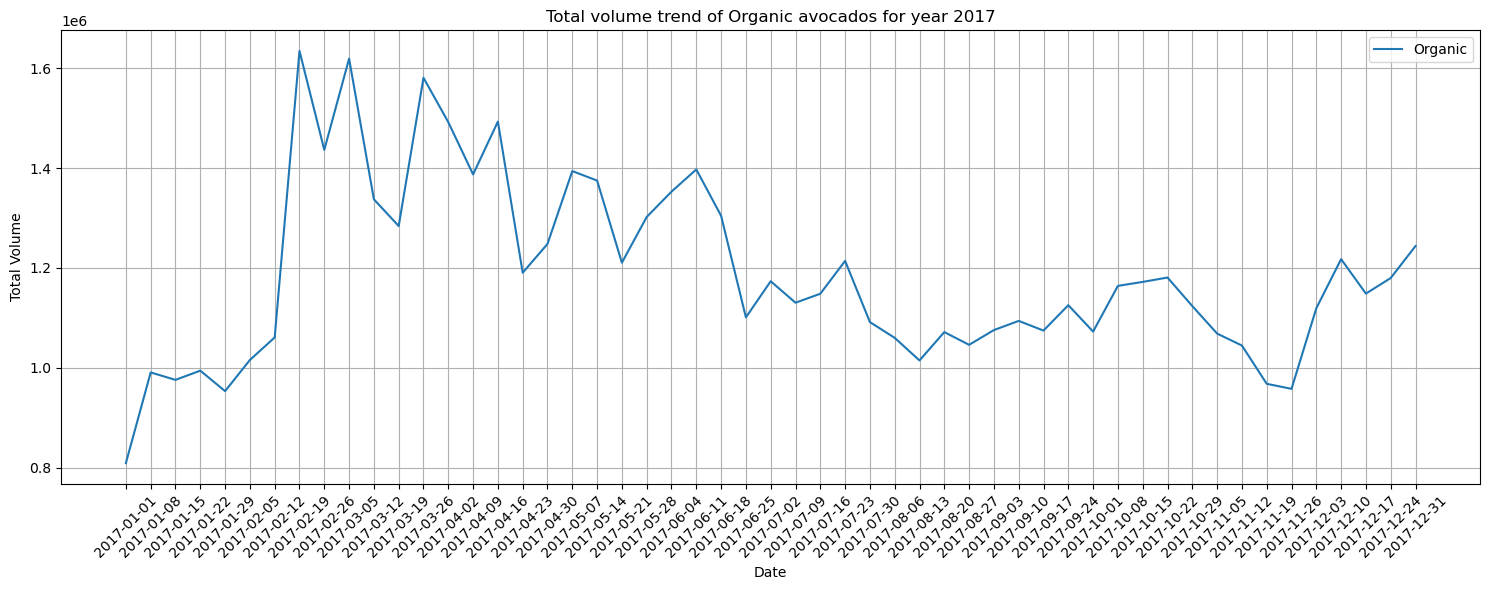

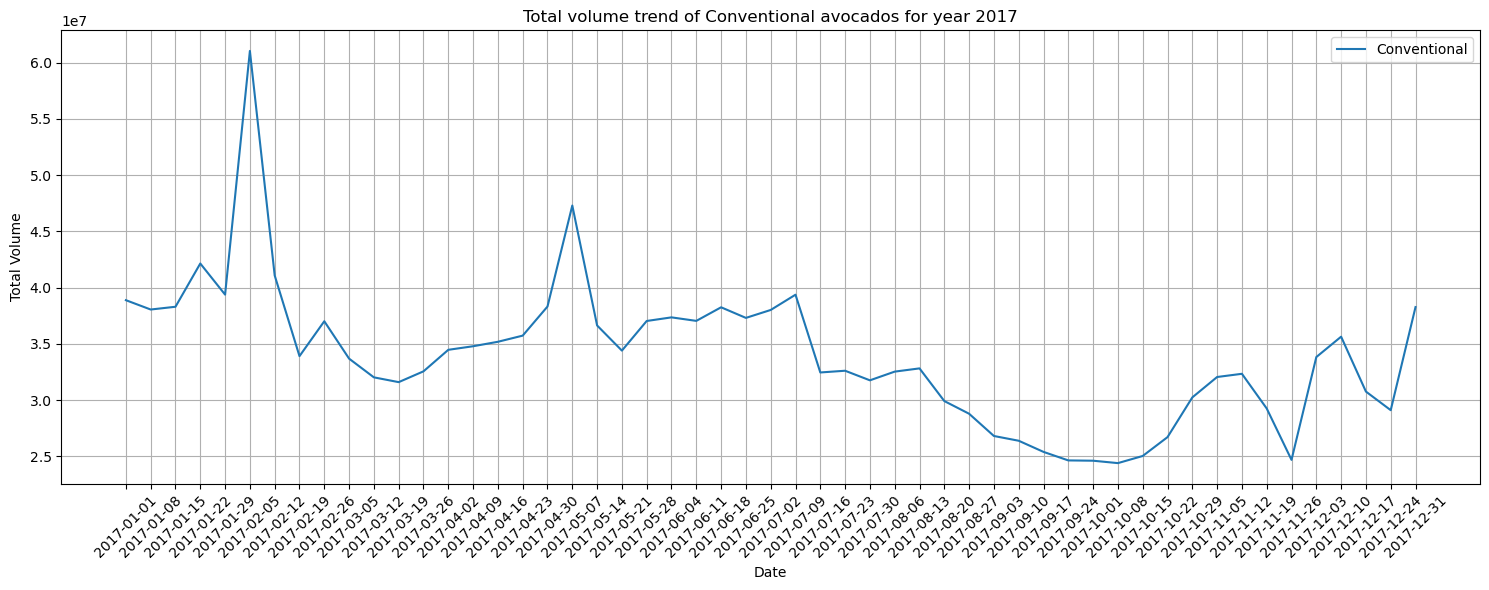

In [67]:
for year in range(2015,2018):
    ## Organic
    year_df = result_df[result_df['year']==year].loc[:]

    year_df.reset_index()
    # Create a line plot
    plt.figure(figsize=(15, 6))
    plt.plot(year_df['Date'], year_df['Organic'], label='Organic')
    # plt.plot(year_df['Date'], year_df['Conventional'], label='Conventional')
    # plt.plot(year_df['Date'], year_df['TotalVolume'], label='Total Volume', linestyle='--')

    # Add labels and a legend
    plt.xlabel('Date')
    plt.ylabel('Total Volume')
    plt.title(f'Total volume trend of Organic avocados for year {year}')
    plt.legend()

    # Rotate x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    ## Conventional
    year_df = result_df[result_df['year']==year].loc[:]

    year_df.reset_index()
    # Create a line plot
    plt.figure(figsize=(15, 6))
    # plt.plot(year_df['Date'], year_df['Organic'], label='Organic')
    plt.plot(year_df['Date'], year_df['Conventional'], label='Conventional')
    # plt.plot(year_df['Date'], year_df['TotalVolume'], label='Total Volume', linestyle='--')

    # Add labels and a legend
    plt.xlabel('Date')
    plt.ylabel('Total Volume')
    plt.title(f'Total volume trend of Conventional avocados for year {year}')
    plt.legend()

    # Rotate x-axis labels for better readability (optional)
    plt.xticks(rotation=45)

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Correlation analysis - calculate correlation coefficients between variables to identify relationships, like price and volume sold. Create a correlation matrix visualization.

## Νormalize columns

### Correlation analysis for conventional avocados in US

In [68]:
# Create scaler 
scaler = MinMaxScaler()
# numerical_cols = ['AveragePrice','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags'] 
numerical_cols = ['AveragePrice','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags'] 
df=total_us_df

# Fit and transform
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [69]:
df = pd.get_dummies(df, columns=['year'])
# for col in df.columns[-4:]:
#     numerical_cols.append(col)
numerical_cols


['AveragePrice',
 'Total Volume',
 '4046',
 '4225',
 '4770',
 'Total Bags',
 'Small Bags',
 'Large Bags',
 'XLarge Bags']

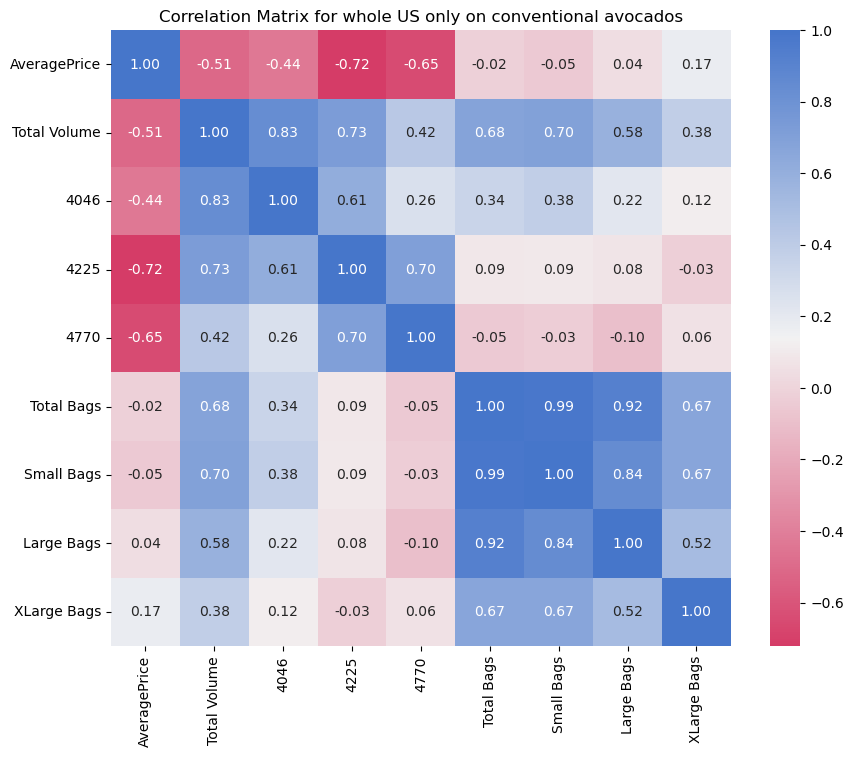

In [70]:
conventional_total_us_df = df[df['type']=='conventional'].loc[:].reset_index(drop=True)

num_cols=[]
for col in numerical_cols:
    if pd.api.types.is_numeric_dtype(conventional_total_us_df[col]):
        num_cols.append(col)

corr_matrix_conventional_us=conventional_total_us_df[num_cols].corr()

# Create a heatmap of the correlation matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_conventional_us, annot=True, cmap=sns.diverging_palette(1, 255, as_cmap=True), fmt=".2f")
plt.title('Correlation Matrix for whole US only on conventional avocados')
plt.show()


#### Top 5 highest and Lowest correlations

In [71]:
correlation_matrix=corr_matrix_conventional_us

# Replace diagonal elements (correlation of 1) with NaN to exclude them
np.fill_diagonal(correlation_matrix.values, np.nan)

# Flatten the correlation matrix
correlation_values = correlation_matrix.values.flatten()

# Sort the correlation values in ascending order and get the indices
sorted_indices = np.argsort(correlation_values)

# Get the 5 lowest correlations
lowest_corr_indices = sorted_indices[:10]
lowest_corr_values = correlation_values[lowest_corr_indices]
lowest_corr_vars = [
    (
        correlation_matrix.columns[i // correlation_matrix.shape[0]],
        correlation_matrix.columns[i % correlation_matrix.shape[0]]
    )
    for i in lowest_corr_indices
]

# Print the 5 lowest and 5 highest correlations
print("\n5 Lowest Correlations:")
for i, (var1, var2) in enumerate(lowest_corr_vars):
    print(f"{i + 1}. Variables: {var1} and {var2}, Correlation Value: {correlation_values[lowest_corr_indices[i]]:.2f}")

# Replace NaN values with a very low value (e.g., -2) to exclude them
correlation_matrix = correlation_matrix.fillna(-2)

# Find the indices of the 5 highest correlations (excluding NaN)
highest_corr_indices = np.unravel_index(np.argsort(correlation_matrix.values, axis=None)[-10:], correlation_matrix.shape)
highest_corr_values = correlation_matrix.values[highest_corr_indices]

# Get the variable pairs for the 5 highest correlations
highest_corr_vars = [
    (
        correlation_matrix.columns[highest_corr_indices[0][i]],
        correlation_matrix.columns[highest_corr_indices[1][i]]
    )
    for i in range(10)
]

# Print the 5 highest correlations
print("\n5 Highest Correlations (Excluding NaN):")
for i, (var1, var2) in enumerate(highest_corr_vars):
    print(f"{i + 1}. Variables: {var1} and {var2}, Correlation Value: {highest_corr_values[i]:.2f}")



5 Lowest Correlations:
1. Variables: AveragePrice and 4225, Correlation Value: -0.72
2. Variables: 4225 and AveragePrice, Correlation Value: -0.72
3. Variables: 4770 and AveragePrice, Correlation Value: -0.65
4. Variables: AveragePrice and 4770, Correlation Value: -0.65
5. Variables: AveragePrice and Total Volume, Correlation Value: -0.51
6. Variables: Total Volume and AveragePrice, Correlation Value: -0.51
7. Variables: AveragePrice and 4046, Correlation Value: -0.44
8. Variables: 4046 and AveragePrice, Correlation Value: -0.44
9. Variables: 4770 and Large Bags, Correlation Value: -0.10
10. Variables: Large Bags and 4770, Correlation Value: -0.10

5 Highest Correlations (Excluding NaN):
1. Variables: Total Volume and 4225, Correlation Value: 0.73
2. Variables: 4225 and Total Volume, Correlation Value: 0.73
3. Variables: Total Volume and 4046, Correlation Value: 0.83
4. Variables: 4046 and Total Volume, Correlation Value: 0.83
5. Variables: Small Bags and Large Bags, Correlation Value

#### Top 5 highest and Lowest correlations for AveragePrice column

In [72]:
column1 = 'AveragePrice'

# Extract the correlations of 'AveragePrice' with the rest of the columns
correlations_with_column1 = correlation_matrix.loc[column1].drop(column1)

# Get the top 5 highest correlations for 'AveragePrice'
top_5_highest_corr_with_column1 = correlations_with_column1.nlargest(5)
bottom_5_lowest_corr_with_column1 = correlations_with_column1.nsmallest(5)

# Print the top 5 highest correlations for 'AveragePrice'
print(f"\nTop 5 Highest Correlations with {column1}:")
print(top_5_highest_corr_with_column1)

# Print the 5 lowest correlations for 'AveragePrice'
print(f"\n5 Lowest Correlations with {column1}:")
print(bottom_5_lowest_corr_with_column1)



Top 5 Highest Correlations with AveragePrice:
XLarge Bags    0.174164
Large Bags     0.038424
Total Bags    -0.017696
Small Bags    -0.050656
4046          -0.436403
Name: AveragePrice, dtype: float64

5 Lowest Correlations with AveragePrice:
4225           -0.721843
4770           -0.651157
Total Volume   -0.509960
4046           -0.436403
Small Bags     -0.050656
Name: AveragePrice, dtype: float64


#### Top 5 highest and Lowest correlations for Total Volume column

In [73]:
column2 = 'Total Volume'

# Extract the correlations of 'Total Volume' with the rest of the columns
correlations_with_column2 = correlation_matrix.loc[column2].drop(column2)

# Get the top 5 highest correlations for 'Total Volume'
top_5_highest_corr_with_column2 = correlations_with_column2.nlargest(5)
bottom_5_lowest_corr_with_column2 = correlations_with_column2.nsmallest(5)

# Print the top 5 highest correlations for 'Total Volume'

print(f"\nTop 5 Highest Correlations with {column2}:")
print(top_5_highest_corr_with_column2)

# Print the 5 lowest correlations for 'Total Volume'
print(f"\n5 Lowest Correlations with {column2}:")
print(bottom_5_lowest_corr_with_column2)



Top 5 Highest Correlations with Total Volume:
4046          0.834106
4225          0.728330
Small Bags    0.697059
Total Bags    0.683570
Large Bags    0.584132
Name: Total Volume, dtype: float64

5 Lowest Correlations with Total Volume:
AveragePrice   -0.509960
XLarge Bags     0.384612
4770            0.423831
Large Bags      0.584132
Total Bags      0.683570
Name: Total Volume, dtype: float64


Based on the heatmap that we can see above there are some correlation that seem important to note.



### Correlation analysis for organic avocados in US

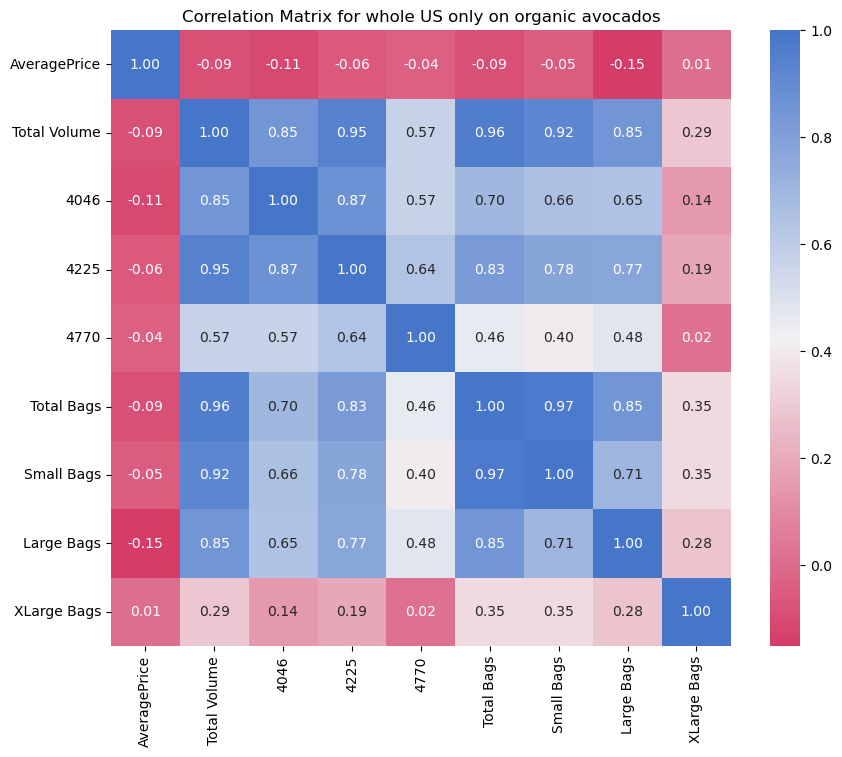

In [74]:
yolo_df = avocado_df[(avocado_df['type']=='organic')].loc[:].reset_index(drop=True)

num_cols=[]
for col in yolo_df.columns[1:-3]:
    if pd.api.types.is_numeric_dtype(yolo_df[col]):
        num_cols.append(col)

corr_matrix_organic_us=yolo_df[num_cols].corr()# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_organic_us, annot=True, cmap=sns.diverging_palette(1, 255, as_cmap=True), fmt=".2f")
plt.title('Correlation Matrix for whole US only on organic avocados')
plt.show()


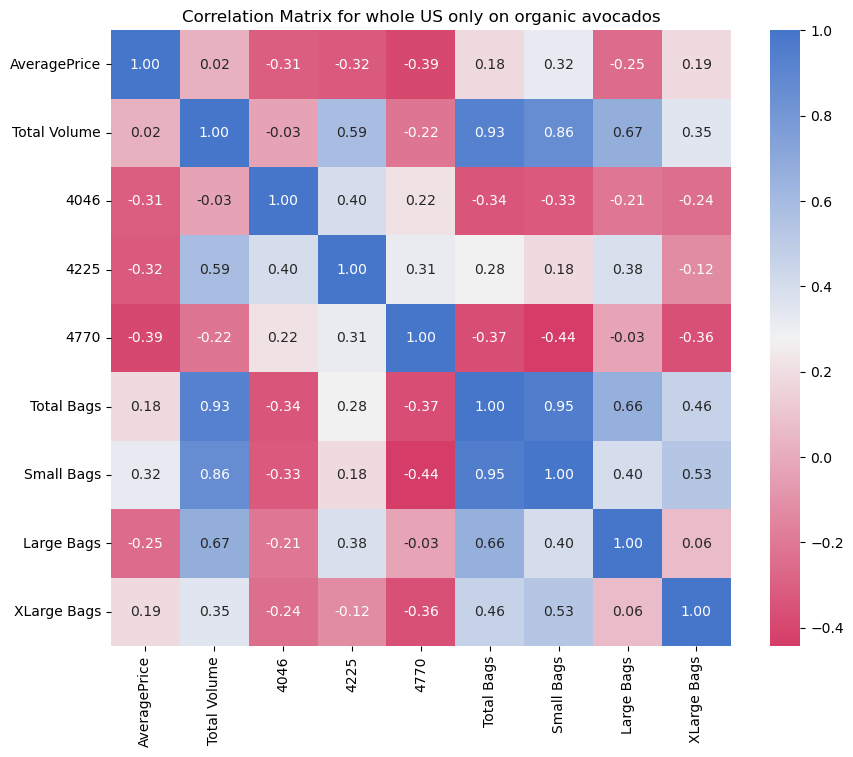

In [75]:
organic_total_us_df = total_us_df[(total_us_df['type']=='organic') & (total_us_df['region']=='TotalUS')].loc[:].reset_index(drop=True)

num_cols=[]
for col in organic_total_us_df.columns[1:-3]:
    if pd.api.types.is_numeric_dtype(organic_total_us_df[col]):
        num_cols.append(col)

corr_matrix_organic_us=organic_total_us_df[num_cols].corr()# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_organic_us, annot=True, cmap=sns.diverging_palette(1, 255, as_cmap=True), fmt=".2f")
plt.title('Correlation Matrix for whole US only on organic avocados')
plt.show()


In [76]:
correlation_matrix=corr_matrix_organic_us

# Replace diagonal elements (correlation of 1) with NaN to exclude them
np.fill_diagonal(correlation_matrix.values, np.nan)

# Flatten the correlation matrix
correlation_values = correlation_matrix.values.flatten()

# Sort the correlation values in ascending order and get the indices
sorted_indices = np.argsort(correlation_values)

# Get the 5 lowest correlations
lowest_corr_indices = sorted_indices[:10]
lowest_corr_values = correlation_values[lowest_corr_indices]
lowest_corr_vars = [
    (
        correlation_matrix.columns[i // correlation_matrix.shape[0]],
        correlation_matrix.columns[i % correlation_matrix.shape[0]]
    )
    for i in lowest_corr_indices
]

# Print the 5 lowest and 5 highest correlations
print("\n5 Lowest Correlations:")
for i, (var1, var2) in enumerate(lowest_corr_vars):
    print(f"{i + 1}. Variables: {var1} and {var2}, Correlation Value: {correlation_values[lowest_corr_indices[i]]:.2f}")

# Replace NaN values with a very low value (e.g., -2) to exclude them
correlation_matrix = correlation_matrix.fillna(-2)

# Find the indices of the 5 highest correlations (excluding NaN)
highest_corr_indices = np.unravel_index(np.argsort(correlation_matrix.values, axis=None)[-10:], correlation_matrix.shape)
highest_corr_values = correlation_matrix.values[highest_corr_indices]

# Get the variable pairs for the 5 highest correlations
highest_corr_vars = [
    (
        correlation_matrix.columns[highest_corr_indices[0][i]],
        correlation_matrix.columns[highest_corr_indices[1][i]]
    )
    for i in range(10)
]

# Print the 5 highest correlations
print("\n5 Highest Correlations (Excluding NaN):")
for i, (var1, var2) in enumerate(highest_corr_vars):
    print(f"{i + 1}. Variables: {var1} and {var2}, Correlation Value: {highest_corr_values[i]:.2f}")



5 Lowest Correlations:
1. Variables: 4770 and Small Bags, Correlation Value: -0.44
2. Variables: Small Bags and 4770, Correlation Value: -0.44
3. Variables: 4770 and AveragePrice, Correlation Value: -0.39
4. Variables: AveragePrice and 4770, Correlation Value: -0.39
5. Variables: 4770 and Total Bags, Correlation Value: -0.37
6. Variables: Total Bags and 4770, Correlation Value: -0.37
7. Variables: XLarge Bags and 4770, Correlation Value: -0.36
8. Variables: 4770 and XLarge Bags, Correlation Value: -0.36
9. Variables: 4046 and Total Bags, Correlation Value: -0.34
10. Variables: Total Bags and 4046, Correlation Value: -0.34

5 Highest Correlations (Excluding NaN):
1. Variables: Total Bags and Large Bags, Correlation Value: 0.66
2. Variables: Large Bags and Total Bags, Correlation Value: 0.66
3. Variables: Large Bags and Total Volume, Correlation Value: 0.67
4. Variables: Total Volume and Large Bags, Correlation Value: 0.67
5. Variables: Total Volume and Small Bags, Correlation Value: 0.

In [30]:
column1 = 'AveragePrice'

# Extract the correlations of 'AveragePrice' with the rest of the columns
correlations_with_column1 = correlation_matrix.loc[column1].drop(column1)

# Get the top 5 highest correlations for 'AveragePrice'
top_5_highest_corr_with_column1 = correlations_with_column1.nlargest(5)
bottom_5_lowest_corr_with_column1 = correlations_with_column1.nsmallest(5)

# Print the top 5 highest correlations for 'AveragePrice'
print(f"\nTop 5 Highest Correlations with {column1}:")
print(top_5_highest_corr_with_column1)

# Print the 5 lowest correlations for 'AveragePrice'
print(f"\n5 Lowest Correlations with {column1}:")
print(bottom_5_lowest_corr_with_column1)



Top 5 Highest Correlations with AveragePrice:
Small Bags      0.318327
XLarge Bags     0.187186
Total Bags      0.178775
Total Volume    0.024432
Large Bags     -0.252887
Name: AveragePrice, dtype: float64

5 Lowest Correlations with AveragePrice:
4770           -0.393561
4225           -0.321156
4046           -0.306326
Large Bags     -0.252887
Total Volume    0.024432
Name: AveragePrice, dtype: float64


In [31]:
column2 = 'Total Volume'

# Extract the correlations of 'Total Volume' with the rest of the columns
correlations_with_column2 = correlation_matrix.loc[column2].drop(column2)

# Get the top 5 highest correlations for 'Total Volume'
top_5_highest_corr_with_column2 = correlations_with_column2.nlargest(5)
bottom_5_lowest_corr_with_column2 = correlations_with_column2.nsmallest(5)

# Print the top 5 highest correlations for 'Total Volume'

print(f"\nTop 5 Highest Correlations with {column2}:")
print(top_5_highest_corr_with_column2)

# Print the 5 lowest correlations for 'Total Volume'
print(f"\n5 Lowest Correlations with {column2}:")
print(bottom_5_lowest_corr_with_column2)



Top 5 Highest Correlations with Total Volume:
Total Bags     0.930180
Small Bags     0.864594
Large Bags     0.667414
4225           0.585107
XLarge Bags    0.347537
Name: Total Volume, dtype: float64

5 Lowest Correlations with Total Volume:
4770           -0.215274
4046           -0.032949
AveragePrice    0.024432
XLarge Bags     0.347537
4225            0.585107
Name: Total Volume, dtype: float64


## Identify outliers - use statistical methods or visual inspection to find outlier points that could indicate errors.

### Conventional avocados in whole US

In [32]:
numeric_columns = conventional_total_us_df.select_dtypes(include=[np.number])

# Calculate the Z-scores for the numeric columns
z_scores = np.abs(stats.zscore(numeric_columns))

# Define the threshold for identifying outliers
threshold = 3

# Create a mask to identify outlier rows
outlier_mask = (z_scores > threshold).any(axis=1)

# Get the rows containing outliers
outliers = conventional_total_us_df[outlier_mask]

# Print or further analyze the rows containing outliers
print("Rows containing outliers:")
outliers


Rows containing outliers:


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,WeekOfYear,year_2015,year_2016,year_2017,year_2018
4,47,2015-02-01,0.097744,0.712112,0.831880,0.925310,0.542379,0.273438,0.311328,0.192779,0.085009,conventional,TotalUS,5,1,0,0,0
57,46,2016-02-07,0.000000,0.835221,0.727783,1.000000,1.000000,0.653305,0.676911,0.588137,0.438036,conventional,TotalUS,6,0,1,0,0
78,25,2016-07-03,0.225564,0.636918,0.548454,0.647061,0.691588,0.638185,0.743326,0.327379,1.000000,conventional,TotalUS,27,0,1,0,0
79,24,2016-07-10,0.255639,0.565542,0.502047,0.566240,0.497171,0.573755,0.669485,0.299271,0.823543,conventional,TotalUS,28,0,1,0,0
109,47,2017-02-05,0.007519,0.976273,1.000000,0.992975,0.653498,0.840295,0.938598,0.631182,0.204588,conventional,TotalUS,5,0,0,1,0
142,14,2017-09-24,0.646617,0.389256,0.378306,0.399418,0.150915,0.373139,0.403399,0.310664,0.125556,conventional,TotalUS,38,0,0,1,0
143,13,2017-10-01,0.661654,0.388828,0.364630,0.402317,0.150832,0.384821,0.408728,0.339029,0.111812,conventional,TotalUS,39,0,0,1,0
144,12,2017-10-08,0.669173,0.385385,0.389722,0.365566,0.153598,0.382523,0.403538,0.342998,0.115860,conventional,TotalUS,40,0,0,1,0
157,11,2018-01-07,0.278195,0.583857,0.602370,0.522031,0.265902,0.591757,0.612942,0.545624,0.272660,conventional,TotalUS,41,0,0,0,1
158,10,2018-01-14,0.330827,0.593482,0.552512,0.575547,0.256118,0.626395,0.605165,0.683727,0.243267,conventional,TotalUS,42,0,0,0,1


#### Average Price

In [33]:
column_to_check = 'AveragePrice'

# Calculate the Z-scores for the selected columns
z_scores = np.abs(stats.zscore(conventional_total_us_df[column_to_check]))

# Define the threshold for identifying outliers
threshold = 3

# Create a mask to identify outlier rows
outlier_mask = z_scores > threshold

# Get the rows containing outliers in the selected column
outliers = conventional_total_us_df[outlier_mask]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'AveragePrice':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,WeekOfYear,year_2015,year_2016,year_2017,year_2018
142,14,2017-09-24,0.646617,0.389256,0.378306,0.399418,0.150915,0.373139,0.403399,0.310664,0.125556,conventional,TotalUS,38,0,0,1,0
143,13,2017-10-01,0.661654,0.388828,0.364630,0.402317,0.150832,0.384821,0.408728,0.339029,0.111812,conventional,TotalUS,39,0,0,1,0
144,12,2017-10-08,0.669173,0.385385,0.389722,0.365566,0.153598,0.382523,0.403538,0.342998,0.115860,conventional,TotalUS,40,0,0,1,0


In [34]:
Q1 = np.percentile(conventional_total_us_df[column_to_check], 25)
Q3 = np.percentile(conventional_total_us_df[column_to_check], 75)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to get rows with outliers in the selected column
outliers = conventional_total_us_df[(conventional_total_us_df[column_to_check] < lower_bound) | (conventional_total_us_df[column_to_check] > upper_bound)]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'AveragePrice':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,WeekOfYear,year_2015,year_2016,year_2017,year_2018
139,17,2017-09-03,0.609023,0.424274,0.427837,0.412713,0.212550,0.405454,0.434170,0.321796,0.395862,conventional,TotalUS,35,0,0,1,0
140,16,2017-09-10,0.601504,0.417446,0.415547,0.403240,0.191346,0.410713,0.447980,0.315276,0.313465,conventional,TotalUS,36,0,0,1,0
141,15,2017-09-17,0.609023,0.401477,0.400400,0.401021,0.163590,0.383123,0.407305,0.333662,0.142301,conventional,TotalUS,37,0,0,1,0
142,14,2017-09-24,0.646617,0.389256,0.378306,0.399418,0.150915,0.373139,0.403399,0.310664,0.125556,conventional,TotalUS,38,0,0,1,0
143,13,2017-10-01,0.661654,0.388828,0.364630,0.402317,0.150832,0.384821,0.408728,0.339029,0.111812,conventional,TotalUS,39,0,0,1,0
144,12,2017-10-08,0.669173,0.385385,0.389722,0.365566,0.153598,0.382523,0.403538,0.342998,0.115860,conventional,TotalUS,40,0,0,1,0
145,11,2017-10-15,0.616541,0.395617,0.383467,0.411191,0.153710,0.374786,0.399320,0.328386,0.098474,conventional,TotalUS,41,0,0,1,0


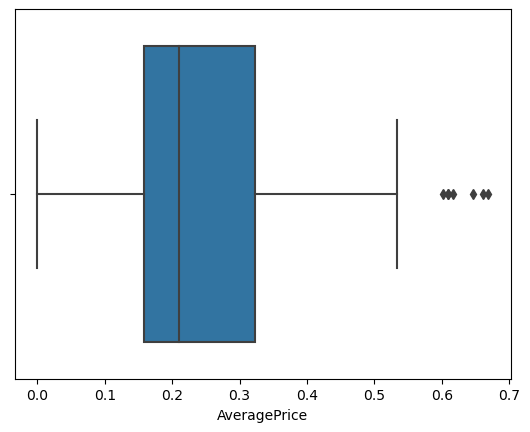

In [35]:
sns.boxplot(x=conventional_total_us_df[column_to_check])
plt.show()


#### Total Volume

In [36]:
column_to_check = 'Total Volume'

# Calculate the Z-scores for the selected columns
z_scores = np.abs(stats.zscore(conventional_total_us_df[column_to_check]))

# Define the threshold for identifying outliers
threshold = 3

# Create a mask to identify outlier rows
outlier_mask = z_scores > threshold

# Get the rows containing outliers in the selected column
outliers = conventional_total_us_df[outlier_mask]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'Total Volume':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,WeekOfYear,year_2015,year_2016,year_2017,year_2018
57,46,2016-02-07,0.000000,0.835221,0.727783,1.000000,1.000000,0.653305,0.676911,0.588137,0.438036,conventional,TotalUS,6,0,1,0,0
109,47,2017-02-05,0.007519,0.976273,1.000000,0.992975,0.653498,0.840295,0.938598,0.631182,0.204588,conventional,TotalUS,5,0,0,1,0
161,7,2018-02-04,0.082707,1.000000,0.950435,0.998763,0.418759,1.000000,1.000000,1.000000,0.488407,conventional,TotalUS,45,0,0,0,1


In [37]:
Q1 = np.percentile(conventional_total_us_df[column_to_check], 25)
Q3 = np.percentile(conventional_total_us_df[column_to_check], 75)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to get rows with outliers in the selected column
outliers = conventional_total_us_df[(conventional_total_us_df[column_to_check] < lower_bound) | (conventional_total_us_df[column_to_check] > upper_bound)]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'Total Volume':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,region,WeekOfYear,year_2015,year_2016,year_2017,year_2018
57,46,2016-02-07,0.000000,0.835221,0.727783,1.000000,1.000000,0.653305,0.676911,0.588137,0.438036,conventional,TotalUS,6,0,1,0,0
109,47,2017-02-05,0.007519,0.976273,1.000000,0.992975,0.653498,0.840295,0.938598,0.631182,0.204588,conventional,TotalUS,5,0,0,1,0
161,7,2018-02-04,0.082707,1.000000,0.950435,0.998763,0.418759,1.000000,1.000000,1.000000,0.488407,conventional,TotalUS,45,0,0,0,1


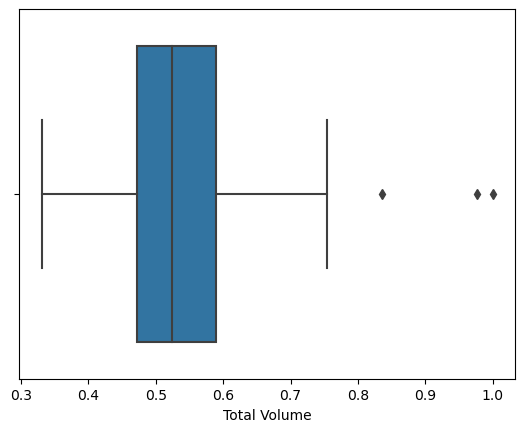

In [38]:
sns.boxplot(x=conventional_total_us_df[column_to_check])
plt.show()


### Organic avocados in whole US

In [39]:
numeric_columns = organic_total_us_df.select_dtypes(include=[np.number])

# Calculate the Z-scores for the numeric columns
z_scores = np.abs(stats.zscore(numeric_columns))

# Define the threshold for identifying outliers
threshold = 3

# Create a mask to identify outlier rows
outlier_mask = (z_scores > threshold).any(axis=1)

# Get the rows containing outliers
outliers = organic_total_us_df[outlier_mask]

# Print or further analyze the rows containing outliers
print("Rows containing outliers:")
outliers


Rows containing outliers:


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear
8,43,2015-03-01,0.481203,0.005043,0.012540,0.003778,0.001855,0.002681,0.005760,0.000000,0.000000,organic,2015,TotalUS,9
16,35,2015-04-26,0.518797,0.005974,0.010764,0.008904,0.002088,0.002343,0.003137,0.004988,0.000000,organic,2015,TotalUS,17
17,34,2015-05-03,0.458647,0.006626,0.010859,0.008967,0.003189,0.004121,0.003582,0.009956,0.000000,organic,2015,TotalUS,18
19,32,2015-05-17,0.556391,0.004196,0.007435,0.005590,0.008324,0.003201,0.003670,0.006641,0.000000,organic,2015,TotalUS,20
69,34,2016-05-01,0.390977,0.013161,0.007113,0.014084,0.008423,0.023495,0.022302,0.031692,0.000000,organic,2016,TotalUS,18
70,33,2016-05-08,0.406015,0.010259,0.002403,0.012081,0.010187,0.021571,0.018599,0.033842,0.000000,organic,2016,TotalUS,19
111,45,2017-02-19,0.413534,0.018274,0.007625,0.021371,0.000967,0.032671,0.027201,0.051259,0.000000,organic,2017,TotalUS,7
113,43,2017-03-05,0.300752,0.018024,0.004688,0.008650,0.000671,0.048759,0.031946,0.094546,0.000000,organic,2017,TotalUS,9
116,40,2017-03-26,0.398496,0.017407,0.003650,0.007728,0.001200,0.048893,0.038634,0.079367,0.000000,organic,2017,TotalUS,12
127,29,2017-06-11,0.601504,0.014445,0.003666,0.006951,0.001096,0.040167,0.029772,0.070586,0.000000,organic,2017,TotalUS,23


#### Average Price

In [40]:
column_to_check = 'AveragePrice'

# Calculate the Z-scores for the selected columns
z_scores = np.abs(stats.zscore(organic_total_us_df[column_to_check]))

# Define the threshold for identifying outliers
threshold = 3

# Create a mask to identify outlier rows
outlier_mask = z_scores > threshold

# Get the rows containing outliers in the selected column
outliers = organic_total_us_df[outlier_mask]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'AveragePrice':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear


In [41]:
Q1 = np.percentile(organic_total_us_df[column_to_check], 25)
Q3 = np.percentile(organic_total_us_df[column_to_check], 75)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to get rows with outliers in the selected column
outliers = organic_total_us_df[(organic_total_us_df[column_to_check] < lower_bound) | (organic_total_us_df[column_to_check] > upper_bound)]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'AveragePrice':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear
26,25,2015-07-05,0.180451,0.002684,0.005617,0.005215,0.002128,0.001686,0.001236,0.007209,0.000000,organic,2015,TotalUS,27
27,24,2015-07-12,0.180451,0.001726,0.004461,0.003378,0.001673,0.001957,0.000632,0.009536,0.000000,organic,2015,TotalUS,28
28,23,2015-07-19,0.180451,0.002396,0.003617,0.005863,0.001541,0.002508,0.000741,0.011147,0.000000,organic,2015,TotalUS,29
29,22,2015-07-26,0.180451,0.001274,0.004067,0.003324,0.001397,0.001059,0.000000,0.007979,0.000000,organic,2015,TotalUS,30
30,21,2015-08-02,0.180451,0.001162,0.003810,0.003181,0.001682,0.001112,0.001601,0.004418,0.000000,organic,2015,TotalUS,31
31,20,2015-08-09,0.180451,0.001991,0.004078,0.003476,0.002385,0.003063,0.004075,0.005231,0.000000,organic,2015,TotalUS,32
138,18,2017-08-27,1.000000,0.008777,0.001546,0.002565,0.000505,0.029098,0.038837,0.011984,0.000010,organic,2017,TotalUS,34
139,17,2017-09-03,0.977444,0.009253,0.001578,0.002863,0.000559,0.030269,0.037552,0.018928,0.000184,organic,2017,TotalUS,35


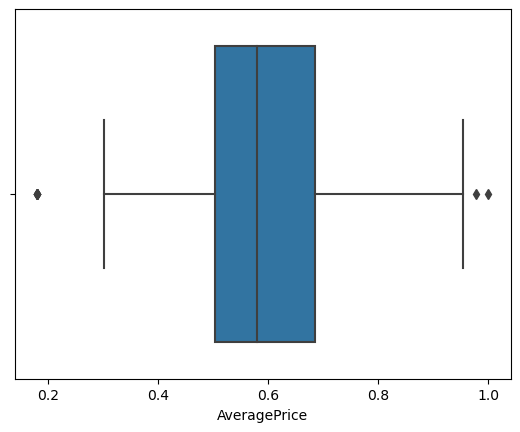

In [42]:
sns.boxplot(x=organic_total_us_df[column_to_check])
plt.show()


#### Total Volume

In [43]:
column_to_check = 'Total Volume'

# Calculate the Z-scores for the selected columns
z_scores = np.abs(stats.zscore(organic_total_us_df[column_to_check]))

# Define the threshold for identifying outliers
threshold = 3

# Create a mask to identify outlier rows
outlier_mask = z_scores > threshold

# Get the rows containing outliers in the selected column
outliers = organic_total_us_df[outlier_mask]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'Total Volume':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear


In [44]:
Q1 = np.percentile(organic_total_us_df[column_to_check], 25)
Q3 = np.percentile(organic_total_us_df[column_to_check], 75)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to get rows with outliers in the selected column
outliers = organic_total_us_df[(organic_total_us_df[column_to_check] < lower_bound) | (organic_total_us_df[column_to_check] > upper_bound)]

# Print or further analyze the rows containing outliers
print(f"Rows containing outliers in '{column_to_check}':")
outliers


Rows containing outliers in 'Total Volume':


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear


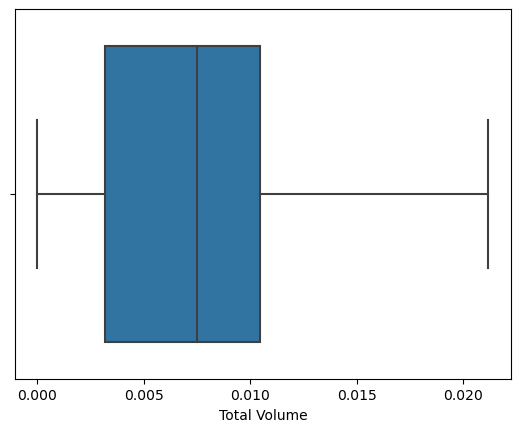

In [45]:
sns.boxplot(x=organic_total_us_df[column_to_check])
plt.show()


## Sort the dataframe by the column *Date*

The first step is to sort the dataframe by date in order to have the records in chronological order from earlier observation to latest

In [46]:
sorted_avocado_df = avocado_df.sort_values(by='Date')

sorted_avocado_df.head()


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear
11569,51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,1
9593,51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,1
10009,51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,1
1819,51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,1
9333,51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,1


## Columns of dataset

Creating the TotalSales column based on the AveragePrice and the Total Volume columns of each observation

In [47]:
sorted_avocado_df['TotalSales'] = sorted_avocado_df['AveragePrice'] * sorted_avocado_df['Total Volume']
sorted_avocado_df['TotalSales'] = sorted_avocado_df['TotalSales'].round(2)

sorted_avocado_df.head()


,weeks_left,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,WeekOfYear,TotalSales
11569,51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,1,47890.31
9593,51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,1,26407.52
10009,51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,1,4866.49
1819,51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,1,83534.34
9333,51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,1,2468.40


In [48]:
column_types = sorted_avocado_df.dtypes
print(column_types)


weeks_left        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
WeekOfYear        int64
TotalSales      float64
dtype: object


## Missing values

As we can see on this dataset there are no missing values

In [49]:
columns = list(sorted_avocado_df)

for column in columns:
    col = Column(column, sorted_avocado_df[column])
    
    print('Column Name : ', col.getName())
    print('Column Null Contents : ', col.getNullContents())


Column Name :  weeks_left
Column Null Contents :  0
Column Name :  Date
Column Null Contents :  0
Column Name :  AveragePrice
Column Null Contents :  0
Column Name :  Total Volume
Column Null Contents :  0
Column Name :  4046
Column Null Contents :  0
Column Name :  4225
Column Null Contents :  0
Column Name :  4770
Column Null Contents :  0
Column Name :  Total Bags
Column Null Contents :  0
Column Name :  Small Bags
Column Null Contents :  0
Column Name :  Large Bags
Column Null Contents :  0
Column Name :  XLarge Bags
Column Null Contents :  0
Column Name :  type
Column Null Contents :  0
Column Name :  year
Column Null Contents :  0
Column Name :  region
Column Null Contents :  0
Column Name :  WeekOfYear
Column Null Contents :  0
Column Name :  TotalSales
Column Null Contents :  0


## Types of avocados

In [50]:
sorted_avocado_df['type'].value_counts()


conventional    9126
organic         9123
Name: type, dtype: int64

In [51]:
regionValueCounts=sorted_avocado_df['region'].value_counts()

regions={}

for name, volume in regionValueCounts.items():
    region=Region(name,volume, sorted_avocado_df)
    regions[region.getName()]=region


# Creation of Model

## Prophet model

### Model for Conventional avocados for TotalUS region

In [ ]:
# Create a Prophet model
model = Prophet()


In [ ]:
df = preprocessDataframeForRegion(sorted_avocado_df,'TotalUS')


In [ ]:
train_pct = 0.8
test_pct=1-train_pct


In [ ]:
# Split the data into training and testing sets
train_size = int(len(df) * train_pct)
train_df =df[:train_size]
test_df = df[train_size:]


In [ ]:
# Fit the model to the training data
model.fit(train_df)


In [ ]:
test_len = int(round(len(df) * test_pct))
test_len


In [ ]:
# Make predictions on the test data
future = model.make_future_dataframe(periods=test_len, freq='W')
forecast = model.predict(future)


In [ ]:
# Visualize the results
fig, ax = plt.subplots(figsize=(10, 6))
model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='black', label='Actual')
ax.legend(loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae = mean_absolute_error(test_df.y, forecast[-test_len:].yhat) 
print('MAE:', mae)

# Root Mean Squared Error 
rmse = mean_squared_error(test_df.y, forecast[-test_len:].yhat, squared=False)
print('RMSE:', rmse)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((test_df.y - forecast[-test_len:].yhat) / test_df.y)) * 100
print('MAPE:', mape)

# R-squared 
r2 = r2_score(test_df.y, forecast[-test_len:].yhat)
print('R-squared:', r2)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

forcst = forecast[-test_len:].yhat
actual = test_df.y

mae = []
rmse = []
r2 = []
for horizon in range(1, len(forcst)+1):
    pred = forcst[:horizon]
    obs = actual[:horizon]
    mae.append(mean_absolute_error(obs, pred))
    rmse.append(mean_squared_error(obs, pred, squared=False))
    r2.append(r2_score(obs, pred))

plt.plot(range(1,test_len+1), mae)
plt.xlabel('Forecast Horizon')  
plt.ylabel('MAE')
plt.title('Forecast Errors vs Horizon')
plt.show()

plt.plot(range(1,test_len+1), rmse)
plt.xlabel('Forecast Horizon')  
plt.ylabel('RMSE')
plt.title('Forecast Errors vs Horizon')
plt.show()

plt.plot(range(1,test_len+1), r2)
plt.xlabel('Forecast Horizon')  
plt.ylabel('R-squared')
plt.title('Forecast Errors vs Horizon')
plt.show()


In [ ]:
import numpy as np

forcst = forecast[-test_len:].reset_index(drop=True).yhat
actual = test_df.reset_index(drop=True).y

direction_accurate = 0
for i in range(1,len(forcst)):
    if (forcst[i] > forcst[i-1]) == (actual[i] > actual[i-1]):
        direction_accurate += 1

directional_accuracy = direction_accurate / (len(forcst)-1)

print('Directional Accuracy:', directional_accuracy)


In [ ]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)


In [ ]:
# models to use
# metrics to compare models (mse, rse etc.)
# ---> use shap
# fix correlation matrix


## XGBOOST model

#### Train and predict for conventional avocados in TotalUS region

In [ ]:
df = preprocessDataframeForRegion(sorted_avocado_df,'TotalUS', 'conventional')

df


In [ ]:
### add cross-validation
### print start-end dates for training and test data
### search what is the default objective on XGBRegressor and check the possible parameters
### apply grid-search on xgboost to provide us with the best parameters
### plot lag1,lag2 & lag3 to understand the data
### try using the difference or the moving average instead of the value for lagged features

# RMSE: 0.07006745317007682
# MAPE: 2.1580055439548267




In [ ]:
grid_search_df=df.loc[:]
grid_search_df['ds'] = grid_search_df['ds'].apply(lambda x: x.timestamp())

for i in [0.7,0.75,0.8,0.85]:
    trainXGBOOSTWithGridSearchCV(grid_search_df,i)


In [ ]:
# train pct: 0.7
# Best parameters found:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
# Lowest RMSE found:  0.5076086474584763
# Best R2 score found:  0.3220822400126684
# train pct: 0.75
# Best parameters found:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
# Lowest RMSE found:  0.32741707703866374
# Best R2 score found:  0.45900072917264445
# train pct: 0.8
# Best parameters found:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}
# Lowest RMSE found:  0.5660690494325971
# Best R2 score found:  0.4958346855923643
# train pct: 0.85
# Best parameters found:  {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
# Lowest RMSE found:  0.6020591958269901
# Best R2 score found:  0.5410793751400721
# train pct: 0.9
# Best parameters found:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
# Lowest RMSE found:  0.4376321838222506
# Best R2 score found:  -1.9949192144841397


In [ ]:
## evaluation metrics
## description of an end to end project

## is dataset imbalanced
## tools and frameworks

# value of cross-validation why it is important and the different implications it can have to the data
# ensure every point is at leas tonce in the test data


train pct: 0.7
RMSE: 0.26221259251268175
MAPE: 15.787291985161508

train pct: 0.75
RMSE: 0.27098529598426135
MAPE: 15.728329541854698

train pct: 0.8
RMSE: 0.28244981967393634
MAPE: 15.289584269040185

train pct: 0.85
RMSE: 0.2320691295473256
MAPE: 12.101536102304104

train pct: 0.9
RMSE: 0.10021067447840387
MAPE: 7.289458503009888

#### Train and predict for organic avocados in TotalUS region

In [ ]:
df = preprocessDataframeForRegion(sorted_avocado_df,'TotalUS', 'organic')


In [ ]:
grid_search_df=df.loc[:]
grid_search_df['ds'] = grid_search_df['ds'].apply(lambda x: x.timestamp())

for i in [0.7,0.75,0.8,0.85]:
    trainXGBOOSTWithGridSearchCV(grid_search_df,i)


In [ ]:
for i in [0.7,0.75,0.8,0.85,0.9]:
    trainXGBOOST(df, i)
